<a href="https://colab.research.google.com/github/sergekamanzi/Fraud-Detection/blob/main/fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.6447 - loss: 0.9776 - val_accuracy: 0.5951 - val_loss: 0.8599
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8252 - loss: 0.8488 - val_accuracy: 0.3737 - val_loss: 0.8365
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8369 - loss: 0.8095 - val_accuracy: 0.4844 - val_loss: 0.8028
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8655 - loss: 0.7654 - val_accuracy: 0.5535 - val_loss: 0.7653
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8736 - loss: 0.7250 - val_accuracy: 0.6547 - val_loss: 0.7195
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8826 - loss: 0.6855 - val_accuracy: 0.7597 - val_loss: 0.6682
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8903 - loss: 0.6442 - val_accuracy: 0.7597 - val_loss: 0.6277
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9040 - loss: 0.6042 - val_accuracy: 0.

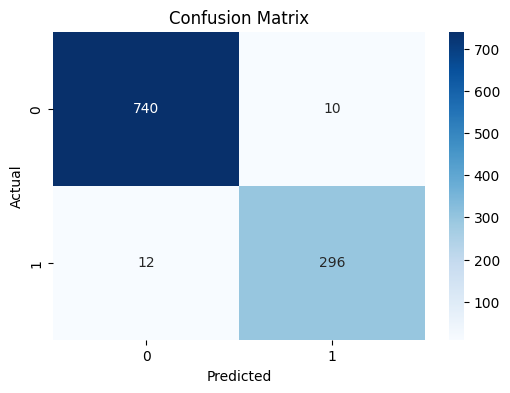

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy

# Load Dataset
data = pd.read_csv('/content/imbalanced_dataset.csv')

# Encode categorical variables
label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])
data['nameOrig'] = label_encoder.fit_transform(data['nameOrig'])
data['nameDest'] = label_encoder.fit_transform(data['nameDest'])

# Feature Engineering
data['balance_change_orig'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['balance_change_dest'] = data['oldbalanceDest'] - data['newbalanceDest']
data['transaction_ratio_orig'] = data['amount'] / (data['oldbalanceOrg'] + 1)
data['transaction_ratio_dest'] = data['amount'] / (data['oldbalanceDest'] + 1)

# Handle missing values
data.fillna(data.median(), inplace=True)

# Drop unnecessary columns
data.drop(columns=['nameDest', 'isFlaggedFraud'], inplace=True)

# Split features and target
X = data.drop(columns=['isFraud'])
Y = data['isFraud']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X_scaled, Y, test_size=0.3, random_state=42, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

# Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train_resampled), y=Y_train_resampled)
class_weights_dict = {0: class_weights[0], 1: class_weights[1] * 3}

# Custom Focal Loss Function
def focal_loss(alpha=0.75, gamma=3):
    def loss(y_true, y_pred):
        bce = binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_term = alpha * K.pow((1 - p_t), gamma)
        return focal_term * bce
    return loss

# Define the Advanced Neural Network Model with L2 Regularization
inputs = Input(shape=(X_train_resampled.shape[1],))

x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

residual = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
residual = BatchNormalization()(residual)
residual = Dropout(0.3)(residual)

x = Add()([x, residual])

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

# Compile Model
optimizer = Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss=focal_loss(alpha=0.75, gamma=3), metrics=['accuracy'])

# Define Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model with Early Stopping
history = model.fit(X_train_resampled, Y_train_resampled,
                    validation_data=(X_val, Y_val),
                    epochs=100, batch_size=256,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping],
                    verbose=1)

# Predict Probabilities
Y_pred_probs = model.predict(X_test)

# Adjust Classification Threshold Using Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(Y_test, Y_pred_probs)
best_threshold = thresholds[np.argmax(2 * (precisions * recalls) / (precisions + recalls))]

# Convert Probabilities to Class Labels
Y_pred = (Y_pred_probs > best_threshold).astype("int32")

# Calculate Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
